# Substitution Matrix Optimization via Genetic Algorithm

This notebook optimizes amino acid substitution matrices using a genetic algorithm to maximize correlations with biochemical properties and codon distances. The algorithm starts from MIYATA matrix and produces MIYATA_EVO.

**Author:** KSS Project  
**Date:** 2025-01-19

## 1. Imports and Configuration

In [1]:
import os
import sys
import random
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from itertools import combinations
from joblib import Parallel, delayed

# Add src to path for main application modules
sys.path.append('../src')
from mutation_score import get_mutational_scores, load_substitution_matrix, save_substitution_matrix

# Import evaluation utilities from local module
from amino_acid_utils import (
    CODON_TABLE,
    AMINO_ACIDS,
    AA_3_TO_1,
    compute_codon_distance,
    get_min_codon_distance,
    calculate_property_distances,
    generate_amino_acid_pairs,
    precompute_codon_distances
)

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)

## 2. Configuration Parameters

In [2]:
# Input/Output paths
INITIAL_MATRIX_PATH = "../src/substitution_matrices/MIYATA.json"
PROPERTIES_FILE = "amino_acid_properties.csv"
OUTPUT_MATRIX_NAME = "../src/substitution_matrices/MIYATA_EVO"
OUTPUT_DIR = "matrix_optimization_results"

# Genetic algorithm parameters
POPULATION_SIZE = 1000
MAX_GENERATIONS = 10000
SELECTION_RATIO = 0.5
MUTATION_RATE = 0.1
MUTATION_AMPLITUDE = 0.1
CROSSOVER_PROBABILITY = 0.5
CROSSOVER_RATE = 0.5

# Early stopping parameters
EARLY_STOP_PATIENCE = 100
EARLY_STOP_MIN_IMPROVEMENT = 1e-6

# Matrix value constraints
MIN_MATRIX_VALUE = 0
MAX_MATRIX_VALUE = 10

# Computational parameters
# N_JOBS = 1 for exact reproducibility (single-threaded)
# N_JOBS = -1 for maximum speed (all cores, but less reproducible across machines)
N_JOBS = 1  # Exact reproducibility

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

## 3. Genetic Code and Reference Data

In [3]:
# Use standard genetic code from amino_acid_utils
print(f"Amino acids: {len(AMINO_ACIDS)}")

# Generate all amino acid pairs using utility function
pairs = generate_amino_acid_pairs()
print(f"Total amino acid pairs: {len(pairs)}")

Amino acids: 20
Total amino acid pairs: 190


## 4. Helper Functions

In [4]:
def extract_upper_triangle(full_matrix):
    """
    Extract unique pairs (i < j) from a full 20x20 matrix.
    Removes diagonal and duplicate symmetric entries.

    400 entries -> 190 entries
    """
    upper = {}
    for (aa1, aa2), value in full_matrix.items():
        if aa1 < aa2:
            upper[(aa1, aa2)] = value
        elif aa1 > aa2 and (aa2, aa1) not in upper:
            upper[(aa2, aa1)] = value
        # aa1 == aa2 -> skip (diagonal)
    return upper


def expand_to_full_matrix(upper_triangle):
    """
    Reconstruct full symmetric 20x20 matrix from upper triangle.
    Diagonal fixed to 0, symmetry guaranteed by construction.

    190 entries -> 400 entries
    """
    full = {}
    amino_acids = sorted(set(aa for pair in upper_triangle for aa in pair))

    # Diagonal = 0 (distance to self is always 0)
    for aa in amino_acids:
        full[(aa, aa)] = 0.0

    # Symmetric pairs
    for (aa1, aa2), value in upper_triangle.items():
        full[(aa1, aa2)] = value
        full[(aa2, aa1)] = value

    return full

## 5. Load Reference Data

In [5]:
# Load amino acid properties using mapping from amino_acid_utils
df_properties = pd.read_csv(PROPERTIES_FILE)
df_properties['AA_1letter'] = df_properties['AA'].map(AA_3_TO_1)
df_properties = df_properties.set_index('AA_1letter')
df_properties = df_properties.drop('AA', axis=1)

print("Amino acid properties loaded:")
display(df_properties.head())

amino_acid_properties = {col: df_properties[col].to_dict() for col in df_properties.columns}
property_names = list(amino_acid_properties.keys())
print(f"\nProperties: {property_names}")

# Compute minimum codon distances using utility function
min_codon_distances = precompute_codon_distances()
print(f"Codon distances computed for {len(min_codon_distances)} pairs")

Amino acid properties loaded:


,Hydrophob.,Polarity,Volume,Area Lost,pI,In-Out,Aroma.
AA_1letter,,,,,,,
A,0.31,8.1,27.5,0.74,6.00,0.20,0.025
R,-1.01,10.5,105.0,0.64,10.76,-1.34,0.750
N,-0.60,11.6,58.7,0.63,5.41,-0.69,0.200
D,-0.77,13.0,40.0,0.62,2.77,-0.72,-0.025
C,1.54,5.5,44.6,0.91,5.05,0.67,0.200



Properties: ['Hydrophob.', 'Polarity', 'Volume', 'Area Lost', 'pI', 'In-Out', 'Aroma.']
Codon distances computed for 190 pairs


## 6. Fitness Function

In [6]:
def evaluate_matrix(upper_triangle):
    """
    Evaluate a substitution matrix by calculating correlations with biochemical
    properties and codon distances.

    Returns:
        float: Composite fitness score (sum of all correlations)
    """
    # Reconstruct full symmetric matrix from upper triangle
    full_matrix = expand_to_full_matrix(upper_triangle)

    # Get mutation scores using the full symmetric matrix
    scores = get_mutational_scores(
        pd.Series(pairs),
        substitution_matrix_type="MIYATA",
        custom_matrix=full_matrix
    )
    scores_array = np.array([scores[p] for p in pairs])

    # Calculate correlations with amino acid properties
    total_score = 0

    for prop_name in property_names:
        prop_distances = calculate_property_distances(amino_acid_properties[prop_name], pairs)
        corr, _ = stats.spearmanr(prop_distances, scores_array)
        total_score += corr

    # Calculate correlation with codon distances
    codon_dist_array = np.array([min_codon_distances[p] for p in pairs])
    corr_codon, _ = stats.spearmanr(codon_dist_array, scores_array)
    total_score += corr_codon

    return total_score

## 7. Genetic Operators

In [7]:
def mutate_matrix(matrix_dict, mutation_rate=MUTATION_RATE, mutation_amplitude=MUTATION_AMPLITUDE):
    """Apply random mutations to a substitution matrix."""
    mutated = matrix_dict.copy()
    
    num_mutations = max(1, int(mutation_rate * len(mutated)))
    keys_to_mutate = random.sample(list(mutated.keys()), num_mutations)
    
    for key in keys_to_mutate:
        delta = random.choice([mutation_amplitude, -mutation_amplitude])
        new_value = mutated[key] + delta
        mutated[key] = np.clip(new_value, MIN_MATRIX_VALUE, MAX_MATRIX_VALUE)
    
    return mutated


def crossover(parent1, parent2, crossover_rate=CROSSOVER_RATE):
    """Perform uniform crossover between two parent matrices."""
    child = {}
    keys = list(parent1.keys())
    random.shuffle(keys)
    
    split_idx = int(len(keys) * crossover_rate)
    keys_from_p1 = set(keys[:split_idx])
    
    for key in parent1.keys():
        child[key] = parent1[key] if key in keys_from_p1 else parent2[key]
    
    return child


def create_offspring(parents):
    """Create a new individual via crossover and mutation."""
    if random.random() < CROSSOVER_PROBABILITY and len(parents) > 1:
        parent1, parent2 = random.sample(parents, 2)
        child = crossover(parent1, parent2)
        return mutate_matrix(child)
    else:
        parent = random.choice(parents)
        return mutate_matrix(parent)

## 8. Early Stopping

Early stopping is implemented directly in the main loop using two simple counters.

## 9. Load Initial Matrix and Evaluate

In [8]:
# Load initial MIYATA matrix
initial_matrix_full = load_substitution_matrix(INITIAL_MATRIX_PATH)
print(f"Loaded initial matrix: {len(initial_matrix_full)} entries")

# Extract upper triangle only (190 pairs, no diagonal)
initial_matrix = extract_upper_triangle(initial_matrix_full)
print(f"Upper triangle: {len(initial_matrix)} entries (symmetric, diagonal=0)")

# Evaluate initial matrix
initial_score = evaluate_matrix(initial_matrix)
print(f"\nInitial MIYATA score: {initial_score:.6f}")

Loaded initial matrix: 400 entries
Upper triangle: 190 entries (symmetric, diagonal=0)

Initial MIYATA score: 3.565837


## 10. Run Genetic Algorithm

In [9]:
# Initialize
print(f"Starting genetic algorithm...")
print(f"Population size: {POPULATION_SIZE}")
print(f"Max generations: {MAX_GENERATIONS}")
print(f"Early stopping patience: {EARLY_STOP_PATIENCE}\n")

# Create initial population
population = [mutate_matrix(initial_matrix) for _ in range(POPULATION_SIZE)]

# Track evolution and early stopping
best_matrix = initial_matrix.copy()
best_score = initial_score
no_improvement_count = 0
evolution_history = {
    'best_scores': [],
    'generation_scores': []
}

# Evolution loop
for generation in range(MAX_GENERATIONS):
    # Evaluate population in parallel
    scores = Parallel(n_jobs=N_JOBS)(
        delayed(evaluate_matrix)(individual) for individual in population
    )
    
    # Sort by fitness
    sorted_pop = sorted(zip(population, scores), key=lambda x: x[1], reverse=True)
    
    # Update best
    gen_best_matrix, gen_best_score = sorted_pop[0]
    if gen_best_score > best_score:
        best_score = gen_best_score
        best_matrix = gen_best_matrix.copy()
    
    # Track history
    evolution_history['best_scores'].append(best_score)
    evolution_history['generation_scores'].append(gen_best_score)
    
    # Print progress with improvement percentage
    if generation % 10 == 0 or generation < 10:
        improvement_pct = ((best_score - initial_score) / initial_score) * 100
        print(f"Gen {generation:4d}: Current={gen_best_score:.6f}, Best={best_score:.6f} (+{improvement_pct:.2f}%)")
    
    # Early stopping check
    if len(evolution_history['best_scores']) > 1:
        prev_best = evolution_history['best_scores'][-2]
        if best_score > prev_best + EARLY_STOP_MIN_IMPROVEMENT:
            no_improvement_count = 0
        else:
            no_improvement_count += 1
        
        if no_improvement_count >= EARLY_STOP_PATIENCE:
            print(f"\nEarly stopping at generation {generation}")
            print(f"No improvement for {EARLY_STOP_PATIENCE} generations")
            break
    
    # Selection
    n_survivors = int(SELECTION_RATIO * POPULATION_SIZE)
    survivors = [ind for ind, _ in sorted_pop[:n_survivors]]
    
    # Create next generation
    new_population = [best_matrix.copy()]  # Elitism
    
    while len(new_population) < POPULATION_SIZE:
        offspring = create_offspring(survivors)
        new_population.append(offspring)
    
    population = new_population[:POPULATION_SIZE]

print(f"\nOptimization completed!")
print(f"Generations: {len(evolution_history['best_scores'])}")
print(f"Initial score: {initial_score:.6f}")
print(f"Final score: {best_score:.6f}")
print(f"Improvement: {best_score - initial_score:+.6f} ({(best_score - initial_score) / initial_score * 100:+.2f}%)")

Starting genetic algorithm...
Population size: 1000
Max generations: 10000
Early stopping patience: 100

Gen    0: Current=3.590116, Best=3.590116 (+0.68%)
Gen    1: Current=3.600472, Best=3.600472 (+0.97%)
Gen    2: Current=3.604420, Best=3.604420 (+1.08%)
Gen    3: Current=3.618173, Best=3.618173 (+1.47%)
Gen    4: Current=3.629110, Best=3.629110 (+1.77%)
Gen    5: Current=3.651235, Best=3.651235 (+2.39%)
Gen    6: Current=3.654309, Best=3.654309 (+2.48%)
Gen    7: Current=3.672917, Best=3.672917 (+3.00%)
Gen    8: Current=3.681639, Best=3.681639 (+3.25%)
Gen    9: Current=3.684403, Best=3.684403 (+3.33%)
Gen   10: Current=3.697825, Best=3.697825 (+3.70%)
Gen   20: Current=3.816783, Best=3.816783 (+7.04%)
Gen   30: Current=3.955455, Best=3.955455 (+10.93%)
Gen   40: Current=4.033441, Best=4.033441 (+13.11%)
Gen   50: Current=4.138596, Best=4.138596 (+16.06%)
Gen   60: Current=4.234817, Best=4.234817 (+18.76%)
Gen   70: Current=4.307154, Best=4.307154 (+20.79%)
Gen   80: Current=4.378

## 11. Visualize Evolution

Evolution plot saved to: matrix_optimization_results\evolution.png


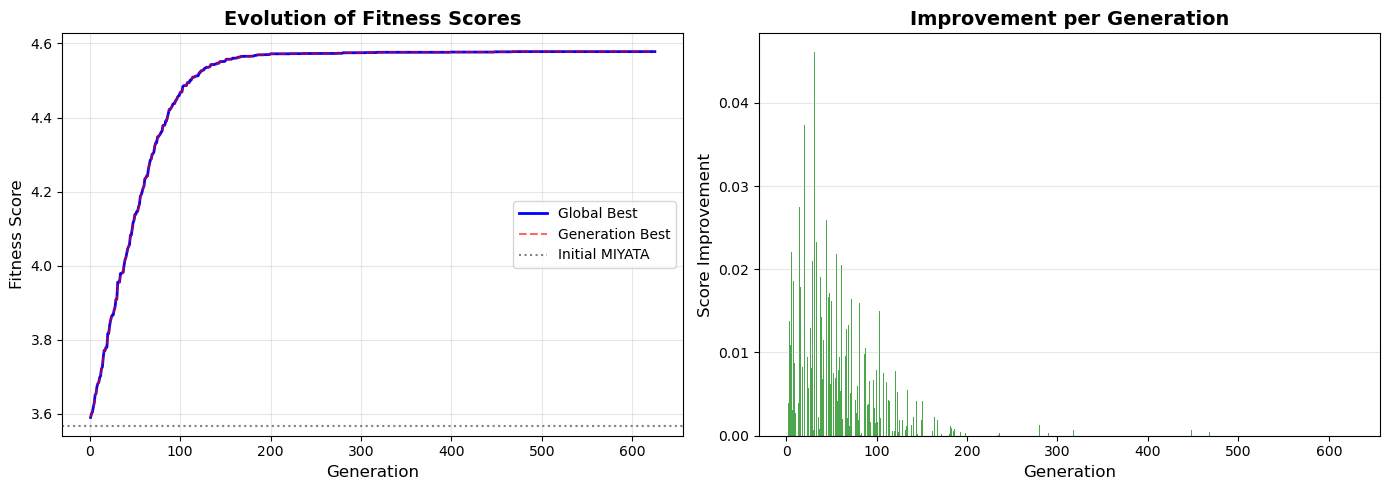

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

generations = range(1, len(evolution_history['best_scores']) + 1)

# Plot 1: Score evolution
ax1.plot(generations, evolution_history['best_scores'], 'b-', linewidth=2, label='Global Best')
ax1.plot(generations, evolution_history['generation_scores'], 'r--', alpha=0.6, label='Generation Best')
ax1.axhline(y=initial_score, color='gray', linestyle=':', label='Initial MIYATA')
ax1.set_xlabel('Generation', fontsize=12)
ax1.set_ylabel('Fitness Score', fontsize=12)
ax1.set_title('Evolution of Fitness Scores', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Improvement per generation
if len(evolution_history['best_scores']) > 1:
    improvements = np.diff(evolution_history['best_scores'])
    ax2.bar(range(2, len(evolution_history['best_scores']) + 1), improvements, alpha=0.7, color='green')
    ax2.set_xlabel('Generation', fontsize=12)
    ax2.set_ylabel('Score Improvement', fontsize=12)
    ax2.set_title('Improvement per Generation', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()

# Save figure
fig_path = os.path.join(OUTPUT_DIR, 'evolution.png')
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"Evolution plot saved to: {fig_path}")

plt.show()

## 12. Save Optimized Matrix

In [14]:
# Expand best upper triangle to full symmetric matrix before saving
best_matrix_full = expand_to_full_matrix(best_matrix)

# Save optimized matrix (use absolute path for Windows compatibility)
import os
output_abs = os.path.abspath(OUTPUT_MATRIX_NAME)
output_files = save_substitution_matrix(best_matrix_full, output_abs, formats=['both'])

print("Optimized MIYATA_EVO matrix saved:")
for fmt, file_path in output_files.items():
    print(f"  - {fmt}: {file_path}")

# Verify by reloading
verified_matrix = load_substitution_matrix(output_abs + '.pkl')
verified_upper = extract_upper_triangle(verified_matrix)
verified_score = evaluate_matrix(verified_upper)

print(f"\nVerification:")
print(f"Verified score: {verified_score:.6f}")
print(f"Expected score: {best_score:.6f}")

score_match = abs(verified_score - best_score) < 1e-6
print(f"Score match: {'✓' if score_match else '✗'}")

# Verify symmetry
asymmetric = sum(1 for (a, b), v in verified_matrix.items()
                if a != b and abs(v - verified_matrix.get((b, a), -1)) > 1e-10)
print(f"Asymmetric pairs: {asymmetric} (should be 0)")

# Verify diagonal
non_zero_diag = sum(1 for (a, b), v in verified_matrix.items()
                    if a == b and abs(v) > 1e-10)
print(f"Non-zero diagonal: {non_zero_diag} (should be 0)")

print(f"Overall: {'✓ PASS' if score_match and asymmetric == 0 and non_zero_diag == 0 else '✗ FAIL'}")

Optimized MIYATA_EVO matrix saved:
  - pickle: c:\Users\lebat\Documents\Projects\KSS\src\substitution_matrices\MIYATA_EVO.pkl
  - json: c:\Users\lebat\Documents\Projects\KSS\src\substitution_matrices\MIYATA_EVO.json

Verification:
Verified score: 4.577906
Expected score: 4.577906
Score match: ✓
Asymmetric pairs: 0 (should be 0)
Non-zero diagonal: 0 (should be 0)
Overall: ✓ PASS


## 13. Summary and Export Results

In [12]:
# Create summary report
summary = {
    'Initial Matrix': 'MIYATA',
    'Optimized Matrix': 'MIYATA_EVO',
    'Initial Score': round(initial_score, 6),
    'Final Score': round(best_score, 6),
    'Improvement': round(best_score - initial_score, 6),
    'Improvement (%)': round((best_score - initial_score) / initial_score * 100, 2),
    'Generations': len(evolution_history['best_scores']),
    'Population Size': POPULATION_SIZE,
    'Mutation Rate': MUTATION_RATE,
    'Mutation Amplitude': MUTATION_AMPLITUDE,
    'Crossover Probability': CROSSOVER_PROBABILITY,
    'Early Stop Patience': EARLY_STOP_PATIENCE
}

df_summary = pd.DataFrame([summary]).T
df_summary.columns = ['Value']

print("\n" + "="*60)
print("OPTIMIZATION SUMMARY")
print("="*60)
display(df_summary)

# Save summary
summary_path = os.path.join(OUTPUT_DIR, 'optimization_summary.csv')
df_summary.to_csv(summary_path)
print(f"\nSummary saved to: {summary_path}")

# Save evolution history
df_history = pd.DataFrame(evolution_history)
df_history['generation'] = range(1, len(df_history) + 1)
history_path = os.path.join(OUTPUT_DIR, 'evolution_history.csv')
df_history.to_csv(history_path, index=False)
print(f"Evolution history saved to: {history_path}")


OPTIMIZATION SUMMARY


,Value
Initial Matrix,MIYATA
Optimized Matrix,MIYATA_EVO
Initial Score,3.565837
Final Score,4.577906
Improvement,1.012069
Improvement (%),28.38
Generations,625
Population Size,1000
Mutation Rate,0.1
Mutation Amplitude,0.1



Summary saved to: matrix_optimization_results\optimization_summary.csv
Evolution history saved to: matrix_optimization_results\evolution_history.csv
